In [1]:
import os 
import torch
import torchvision
import numpy as np

In [2]:
!ls

sample_data


# Getting the Data 

In [3]:
import tarfile
from torchvision.datasets.utils import download_url


In [4]:
url = "http://files.fast.ai/data/cifar10.tgz"
download_url(url,".")

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall('./data')
    
    
    

In [5]:
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test', 'labels.txt']
['frog', 'bird', 'automobile', 'truck', 'airplane', 'cat', 'horse', 'deer', 'dog', 'ship']


In [6]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

trainset = ImageFolder(data_dir + '/train',tt.ToTensor())

In [7]:
trainset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: ToTensor()

In [8]:
mean = [.0,.0,.0]
for tups in trainset:
    for i in range(3):
        mean[i] += torch.mean(tups[0][i])
    

for i in range(3):
    mean[i] = round(mean[i].item()/(50000),4)
    
print(mean)    
        

[0.4914, 0.4822, 0.4465]


In [9]:
std = [.0,.0,.0]

for tups in trainset:
    for i in range(3):
        std[i] += torch.sum((tups[0][i] - mean[i])**2)
        
        
for i in range(3):
    std[i] = round((std[i].item()/(50000*32*32))**(1/2),4)
    
print(std)

[0.247, 0.2435, 0.2616]


In [10]:
stats = (mean,std)

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [11]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [12]:
from torch.utils.data import DataLoader

batch_size = 400

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


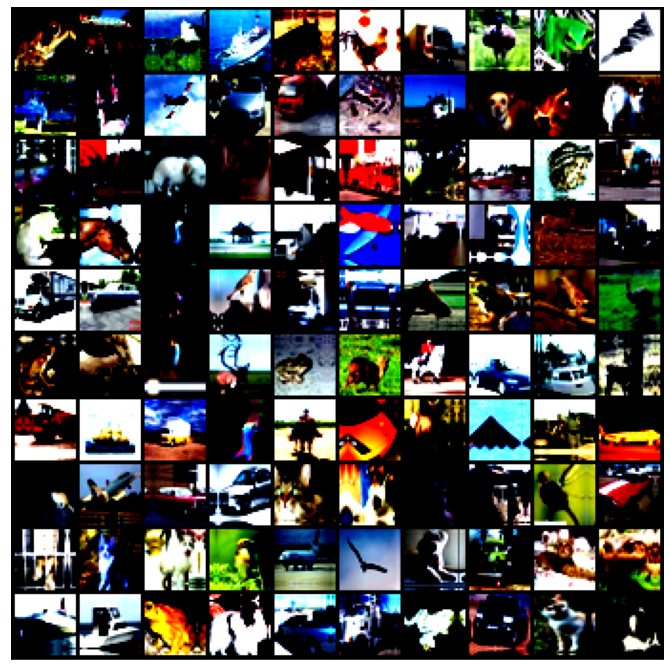

In [13]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# GPU Support

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
get_default_device()

device(type='cuda')

In [15]:
def to_device(data,device):
    
    if isinstance(data,(list,tuple)):
        return [to_device(dat,device) for dat in data]
    return data.to(device,non_blocking = True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""
        
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
train_dl = DeviceDataLoader(train_dl, get_default_device())
valid_dl = DeviceDataLoader(valid_dl, get_default_device())

# Building the Model (ResNet9)

In [26]:
import torch.nn.functional as F

def accuracy(l1,l2):
    probs = F.softmax(l1,dim=1)
    _,preds = torch.max(probs,dim=1)
    
    return torch.tensor(torch.sum(preds == l2).item() / len(l2))

In [18]:
import torch.nn as nn

class ImageClassifyBase(nn.Module):
    
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:

def conv_block(in_channels,out_channels,pool=False):
    layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)



class ResNet9(ImageClassifyBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels,64)
        self.conv2 = conv_block(64,128,True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self,xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        
        return out

In [46]:
model = to_device(ResNet9(3,10),get_default_device())
weights = model.state_dict()

In [91]:
def evaluate(model,val_loader):
    with torch.no_grad():
        model.eval()
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)
    
    
    
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
    
def fit_one_cycle(epochs,max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, lr_sched=False):
    torch.cuda.empty_cache()
    history = []
    
    
    optimizer = opt_func(model.parameters(),max_lr, weight_decay = weight_decay)

    if lr_sched:
      sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))

            if lr_sched:
              sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs

        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [95]:
model1 = to_device(ResNet9(3,10),get_default_device())
model1.load_state_dict(weights)

<All keys matched successfully>

# SGD vs Adam optimizer

In [96]:
epochs = 8
max_lr = 0.01
grad_clip = None
weight_decay = 0
opt_func = torch.optim.SGD

In [97]:
history1 = [evaluate(model1, valid_dl)]
history1 += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 2.3562, val_loss: 1.4326, val_acc: 0.4638
Epoch [1], last_lr: 0.01000, train_loss: 1.5249, val_loss: 1.7537, val_acc: 0.4305
Epoch [2], last_lr: 0.01000, train_loss: 1.3269, val_loss: 1.0777, val_acc: 0.6188
Epoch [3], last_lr: 0.01000, train_loss: 1.1714, val_loss: 1.0776, val_acc: 0.6156
Epoch [4], last_lr: 0.01000, train_loss: 1.0671, val_loss: 1.3503, val_acc: 0.5359
Epoch [5], last_lr: 0.01000, train_loss: 0.9694, val_loss: 0.8963, val_acc: 0.6781
Epoch [6], last_lr: 0.01000, train_loss: 0.9088, val_loss: 1.0741, val_acc: 0.6286
Epoch [7], last_lr: 0.01000, train_loss: 0.8353, val_loss: 0.9505, val_acc: 0.6701


In [98]:
model1.load_state_dict(weights)

<All keys matched successfully>

In [99]:
epochs = 8
max_lr = 0.01
grad_clip = None
weight_decay = 0
opt_func = torch.optim.Adam

In [100]:
history2 = [evaluate(model1, valid_dl)]
history2 += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 2.7294, val_loss: 1.8671, val_acc: 0.3267
Epoch [1], last_lr: 0.01000, train_loss: 1.5769, val_loss: 1.3682, val_acc: 0.5232
Epoch [2], last_lr: 0.01000, train_loss: 1.1905, val_loss: 0.9442, val_acc: 0.6665
Epoch [3], last_lr: 0.01000, train_loss: 0.9236, val_loss: 0.9744, val_acc: 0.6741
Epoch [4], last_lr: 0.01000, train_loss: 0.7450, val_loss: 0.6558, val_acc: 0.7756
Epoch [5], last_lr: 0.01000, train_loss: 0.6299, val_loss: 0.6440, val_acc: 0.7794
Epoch [6], last_lr: 0.01000, train_loss: 0.5516, val_loss: 0.5581, val_acc: 0.8077
Epoch [7], last_lr: 0.01000, train_loss: 0.4813, val_loss: 0.6272, val_acc: 0.7895


Text(0.5, 1.0, 'SGD vs Adam')

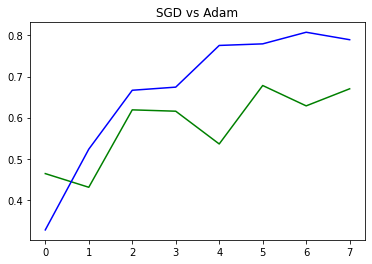

In [101]:
plt.figure()
acc_sgd = [x['val_acc'] for x in history1[1:]]
acc_adam = [x['val_acc'] for x in history2[1:]]
plt.plot(acc_sgd,'g-')
plt.plot(acc_adam,'b-')
plt.title('SGD vs Adam')

# Gradient Clipping

In [104]:
model1.load_state_dict(weights)

epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 0
opt_func = torch.optim.Adam

history3 = [evaluate(model1, valid_dl)]
history3 += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 2.4808, val_loss: 1.7115, val_acc: 0.3724
Epoch [1], last_lr: 0.01000, train_loss: 1.6091, val_loss: 1.4685, val_acc: 0.4812
Epoch [2], last_lr: 0.01000, train_loss: 1.2415, val_loss: 1.0899, val_acc: 0.6118
Epoch [3], last_lr: 0.01000, train_loss: 0.9359, val_loss: 0.9012, val_acc: 0.7021
Epoch [4], last_lr: 0.01000, train_loss: 0.7665, val_loss: 0.7691, val_acc: 0.7262
Epoch [5], last_lr: 0.01000, train_loss: 0.6239, val_loss: 0.5801, val_acc: 0.7975
Epoch [6], last_lr: 0.01000, train_loss: 0.5639, val_loss: 0.5374, val_acc: 0.8134
Epoch [7], last_lr: 0.01000, train_loss: 0.4924, val_loss: 0.5413, val_acc: 0.8158


Text(0.5, 1.0, 'with and without grad clipping')

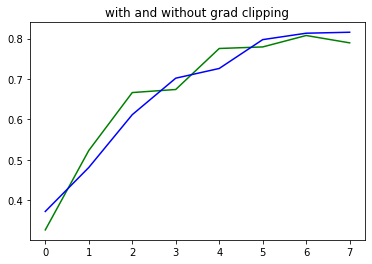

In [105]:
plt.figure()
acc_1 = [x['val_acc'] for x in history2[1:]]
acc_2 = [x['val_acc'] for x in history3[1:]]
plt.plot(acc_1,'g-')
plt.plot(acc_2,'b-')
plt.title('with and without grad clipping')

Text(0.5, 1.0, 'with and without grad clipping')

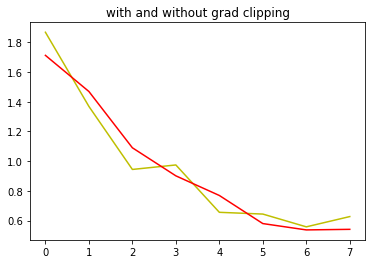

In [146]:
plt.figure()
loss_1 = [x['val_loss'] for x in history2[1:]]
loss_2 = [x['val_loss'] for x in history3[1:]]
plt.plot(loss_1,'y-')
plt.plot(loss_2,'r-')
plt.title('with and without grad clipping')

# weight decay 

In [125]:
model1.load_state_dict(weights)

epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

history4 = [evaluate(model1, valid_dl)]
history4 += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 2.6672, val_loss: 1.8277, val_acc: 0.3273
Epoch [1], last_lr: 0.01000, train_loss: 1.6993, val_loss: 1.5024, val_acc: 0.4376
Epoch [2], last_lr: 0.01000, train_loss: 1.2641, val_loss: 1.2196, val_acc: 0.6011
Epoch [3], last_lr: 0.01000, train_loss: 0.9517, val_loss: 0.8264, val_acc: 0.7103
Epoch [4], last_lr: 0.01000, train_loss: 0.7654, val_loss: 0.8018, val_acc: 0.7376
Epoch [5], last_lr: 0.01000, train_loss: 0.6186, val_loss: 0.7750, val_acc: 0.7412
Epoch [6], last_lr: 0.01000, train_loss: 0.5528, val_loss: 0.5289, val_acc: 0.8208
Epoch [7], last_lr: 0.01000, train_loss: 0.4833, val_loss: 0.5834, val_acc: 0.8091


Text(0.5, 1.0, 'with and without weight decay')

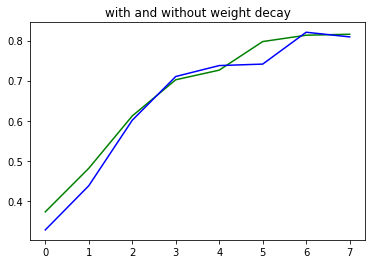

In [126]:
plt.figure()
acc_1 = [x['val_acc'] for x in history3[1:]]
acc_2 = [x['val_acc'] for x in history4[1:]]
plt.plot(acc_1,'g-')
plt.plot(acc_2,'b-')
plt.title('with and without weight decay')

Text(0.5, 1.0, 'with and without weight decay')

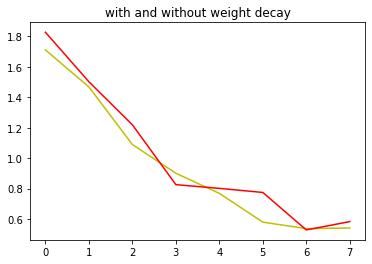

In [145]:
plt.figure()
loss_1 = [x['val_loss'] for x in history3[1:]]
loss_2 = [x['val_loss'] for x in history4[1:]]
plt.plot(loss_1,'y-')
plt.plot(loss_2,'r-')
plt.title('with and without weight decay')

# Learning Rate Scheduling 

In [132]:
model1.load_state_dict(weights)

epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

history5 = [evaluate(model1, valid_dl)]
history5 += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func,lr_sched=True)

Epoch [0], last_lr: 0.00393, train_loss: 1.3518, val_loss: 1.4497, val_acc: 0.5463
Epoch [1], last_lr: 0.00935, train_loss: 1.0142, val_loss: 1.1908, val_acc: 0.6360
Epoch [2], last_lr: 0.00972, train_loss: 0.8089, val_loss: 0.8628, val_acc: 0.7292
Epoch [3], last_lr: 0.00812, train_loss: 0.5724, val_loss: 0.5734, val_acc: 0.8022
Epoch [4], last_lr: 0.00556, train_loss: 0.4244, val_loss: 0.4204, val_acc: 0.8562
Epoch [5], last_lr: 0.00283, train_loss: 0.3278, val_loss: 0.3714, val_acc: 0.8781
Epoch [6], last_lr: 0.00077, train_loss: 0.2476, val_loss: 0.2996, val_acc: 0.8995
Epoch [7], last_lr: 0.00000, train_loss: 0.1935, val_loss: 0.2819, val_acc: 0.9039


Text(0.5, 1.0, 'with and without lr scheduling')

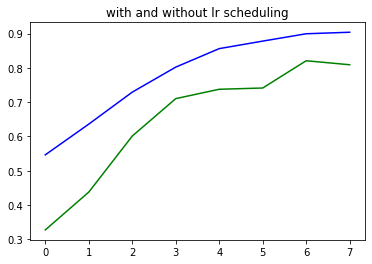

In [133]:
plt.figure()
acc_1 = [x['val_acc'] for x in history4[1:]]
acc_2 = [x['val_acc'] for x in history5[1:]]
plt.plot(acc_1,'g-')
plt.plot(acc_2,'b-')
plt.title('with and without lr scheduling')

Text(0.5, 1.0, 'with and without lr scheduling')

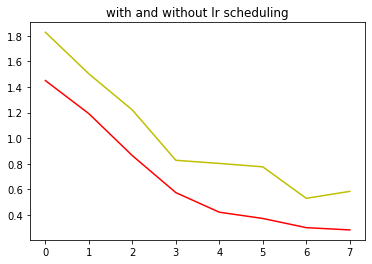

In [144]:
plt.figure()
loss_1 = [x['val_loss'] for x in history4[1:]]
loss_2 = [x['val_loss'] for x in history5[1:]]
plt.plot(loss_1,'y-')
plt.plot(loss_2,'r-')
plt.title('with and without lr scheduling')

Text(0.5, 1.0, 'lr vs batch no. for 8 epochs')

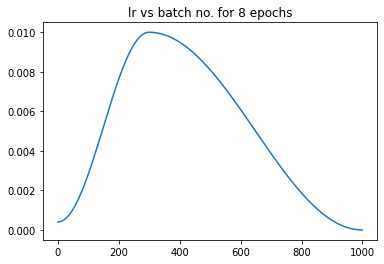

In [141]:
plt.figure()
lrs = np.concatenate([x['lrs'] for x in history5[1:]])
plt.plot(lrs)
plt.title('lr vs batch no. for 8 epochs')

# Training for 25 epochs

In [135]:
model1.load_state_dict(weights)

epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


history6 = [evaluate(model1, valid_dl)]
history6 += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func,lr_sched=True)

Epoch [0], last_lr: 0.00081, train_loss: 1.3195, val_loss: 1.4179, val_acc: 0.5180
Epoch [1], last_lr: 0.00198, train_loss: 0.8454, val_loss: 0.9932, val_acc: 0.6654
Epoch [2], last_lr: 0.00371, train_loss: 0.7219, val_loss: 0.9907, val_acc: 0.6837
Epoch [3], last_lr: 0.00569, train_loss: 0.6404, val_loss: 0.7443, val_acc: 0.7374
Epoch [4], last_lr: 0.00760, train_loss: 0.6137, val_loss: 1.4663, val_acc: 0.5771
Epoch [5], last_lr: 0.00908, train_loss: 0.6010, val_loss: 1.0665, val_acc: 0.6968
Epoch [6], last_lr: 0.00989, train_loss: 0.5333, val_loss: 0.8850, val_acc: 0.7232
Epoch [7], last_lr: 0.00998, train_loss: 0.4703, val_loss: 0.6238, val_acc: 0.7917
Epoch [8], last_lr: 0.00982, train_loss: 0.4442, val_loss: 0.9221, val_acc: 0.7006
Epoch [9], last_lr: 0.00950, train_loss: 0.3972, val_loss: 0.5581, val_acc: 0.8189
Epoch [10], last_lr: 0.00905, train_loss: 0.3769, val_loss: 0.5068, val_acc: 0.8310
Epoch [11], last_lr: 0.00846, train_loss: 0.3515, val_loss: 0.4038, val_acc: 0.8634
Ep

Text(0.5, 1.0, '25 epochs')

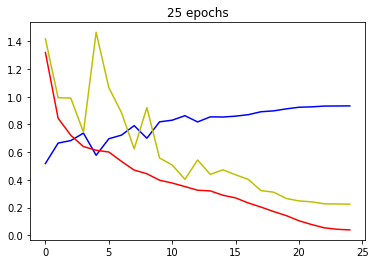

In [137]:
plt.figure()
v_acc = [x['val_acc'] for x in history6[1:]]
v_loss = [x['val_loss'] for x in history6[1:]]
t_loss = [x['train_loss'] for x in history6[1:]]
plt.plot(v_acc,'b-')
plt.plot(v_loss,'y-')
plt.plot(t_loss,'r-')
plt.title('25 epochs')

Text(0.5, 1.0, 'lr vs batch no. for 25 epochs')

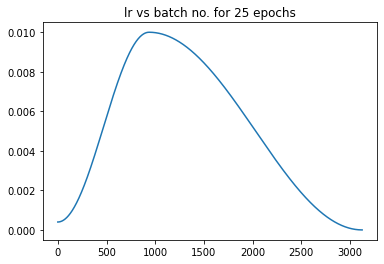

In [142]:
plt.figure()
lrs = np.concatenate([x['lrs'] for x in history6[1:]])
plt.plot(lrs)
plt.title('lr vs batch no. for 25 epochs')

In [148]:
torch.save(model1.state_dict(),'final_weights.pth')
torch.save(weights,'initial_weights.pth')

# ----------------------

In [163]:
testing_ds = ImageFolder(data_dir + '/test',tt.ToTensor())
model2 = ResNet9(3,10)
model2.load_state_dict(torch.load("final_weights.pth"))

<All keys matched successfully>

In [164]:
idx_to_class = {x:y for y,x in testing_ds.class_to_idx.items()}
idx_to_class[9]

'truck'

prediction= truck
label= truck


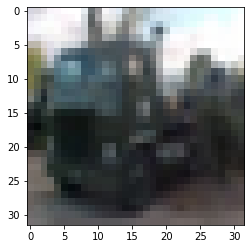

In [179]:
check_img = 9400

norm = tt.Normalize(*stats)

image,label = testing_ds[check_img]
prediction = model2(norm(image).unsqueeze(0))
prediction = F.softmax(prediction,dim=1)
_,prediction = torch.max(prediction,dim=1)
print("prediction=",idx_to_class[prediction.item()])
print("label=",idx_to_class[label])
plt.imshow(image.permute(1,2,0))
